In [1]:
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

using MatrixProductBP
struct Ising2D{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    βh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x


function (f::Ising2D)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = f.βh * spin(xᵢᵗ)
    h += spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + f.βJh*spin(xₙᵢᵗ[f.border ? 2 : 1]))
    exp(h)
end


In [2]:
using Graphs, IndexedGraphs, Graphs.SimpleGraphs, SparseArrays

In [3]:
openchain(n)=spdiagm(-1=>fill(true,n-1),1=>fill(true,n-1))
periodicchain(n)=(x=openchain(n); x[n,1]=x[1,n]=true; x)

periodicchain (generic function with 1 method)

In [5]:
βJ = 0.5
βh = 1e-3
N = 100
T = N
G = IndexedBiDiGraph(periodicchain(N))

w = [[Ising2D(βJ, βJ, βh, i == N || i == 1) for t=0:T] for i=1:N]
bp = mpbp(G, w, fill(2,N), T);


In [6]:
reset!(bp)
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [7]:
svd_trunc = TruncBondThresh(12, 1e-6)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.2);

Running MPBP: iter 2 	 Time: 0:00:22
  Δ:                  0.7637190316443383
  SVD tolerance, m':  1.0e-6, 12

Running MPBP: iter 3 	 Time: 0:00:34
  Δ:                  0.11593810177482511
  SVD tolerance, m':  1.0e-6, 12

Running MPBP: iter 4 	 Time: 0:00:53
  Δ:                  0.08031571533680537
  SVD tolerance, m':  1.0e-6, 12

Running MPBP: iter 5 	 Time: 0:01:25
  Δ:                  0.0572186971963784
  SVD tolerance, m':  1.0e-6, 12

Running MPBP: iter 6 	 Time: 0:02:05
  Δ:                  0.0413844043513123
  SVD tolerance, m':  1.0e-6, 12

Running MPBP: iter 7 	 Time: 0:02:49
  Δ:                  0.030259835718688732
  SVD tolerance, m':  1.0e-6, 12

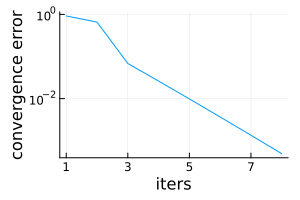

In [46]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [47]:
m_bp = means(spin, bp);

In [48]:
m_bp

100-element Vector{Vector{Float64}}:
 [0.820594184294714, 0.9178679276274102, 0.940792754515992, 0.9462418516431577, 0.94753087884876, 0.947834742521284, 0.9479095955863375, 0.9479269526962044, 0.9479309153293975, 0.9479318216570596  …  0.9479309150939561, 0.9479269507601011, 0.9479095859960234, 0.9478347392169062, 0.9475308809989287, 0.9462418452290902, 0.9407927522142198, 0.9178679218201793, 0.8205941787631053, 0.37921064915411923]
 [0.820594184294714, 0.9178679276274102, 0.940792754515992, 0.9462418516431578, 0.9475308788487601, 0.947834742521284, 0.9479095955863375, 0.9479269526962044, 0.9479309153293977, 0.9479318216570596  …  0.9479309150939561, 0.9479269507601011, 0.9479095859960234, 0.9478347392169062, 0.9475308809989285, 0.9462418452290903, 0.9407927522142199, 0.9178679218201793, 0.8205941787631053, 0.3792106491541191]
 [0.8205941842947142, 0.9178679276274102, 0.940792754515992, 0.9462418516431577, 0.9475308788487599, 0.9478347425212839, 0.9479095955863375, 0.9479269526962045,

In [ ]:
0.9479347370740019